In [1]:
%config Completer.use_jedi = False

## Dataset info

Постановка задачи
Требуется на основании демографических данных о клиентах банка, истории их платежей и состоянии счета, предсказать невыполнение их обязательств по кредитной карте в следующем месяце.

Описание датасета

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

#### Import necessary libraries 

In [212]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from catboost import CatBoost
from catboost import CatBoostClassifier, Pool
import catboost as catb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix, \
                             accuracy_score, classification_report, plot_confusion_matrix, \
                             plot_precision_recall_curve, precision_recall_curve, recall_score,
                             plot_roc_curve, f1_score)

import warnings


warnings.filterwarnings('ignore')

%matplotlib inline

#### Import dataset

In [3]:
train_dataset_path = '/Users/sergeismolnikov/Desktop/ML/GeekBrains/gb_ml_lib2/course_project_train.csv'
test_dataset_path = '/Users/sergeismolnikov/Desktop/ML/GeekBrains/gb_ml_lib2/course_project_test.csv'
train_df = pd.read_csv(train_dataset_path)
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


# Посмотрим на каждый из признаков

<function matplotlib.pyplot.show(close=None, block=None)>

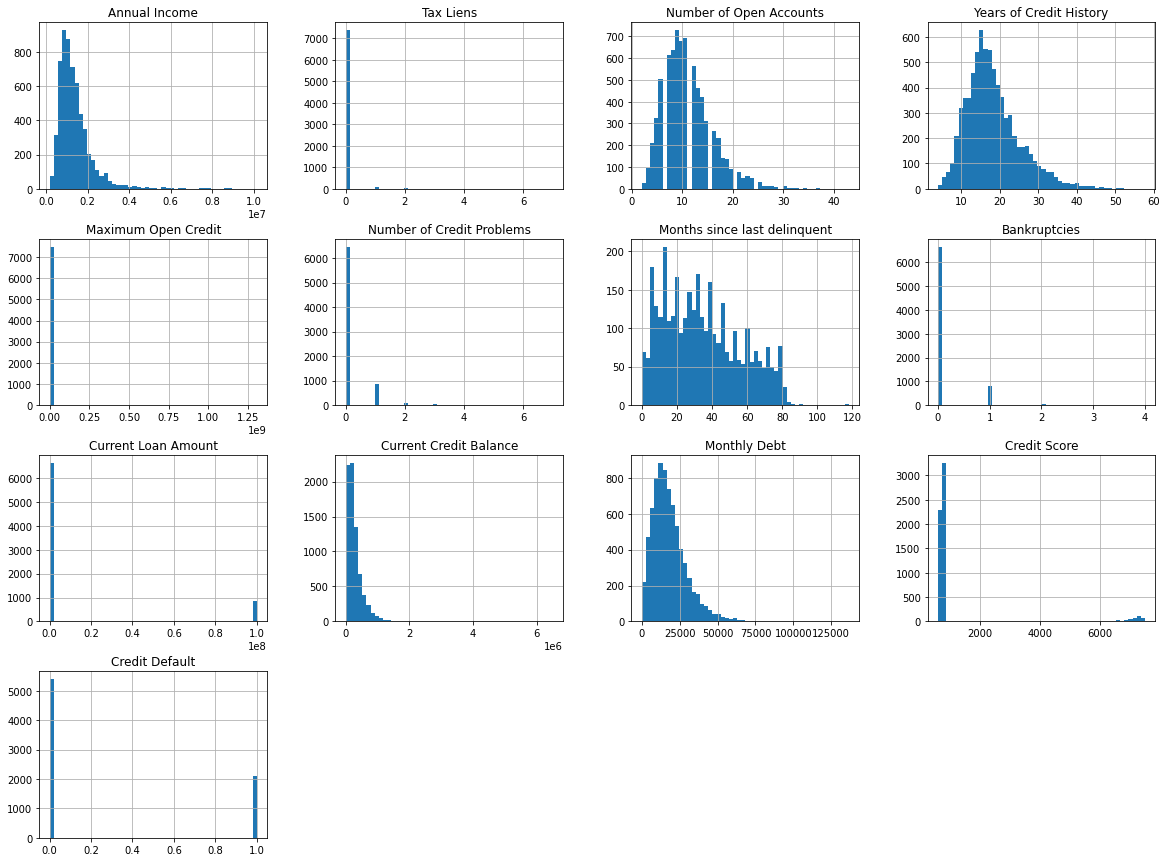

In [4]:
train_df.hist(bins=50, figsize=(20,15))
plt.show

In [34]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

# Обработка выбросов

Исходя из исследовательского обзора данных, были выявлены следующие признаки, в которых присутствуют выбросы

Credit Score 

Current Loan Amount

Maximum Open Credit

Months since last delinquent

### Credit score 

Должен лежать в пределах 300-850 (https://credit.org/blog/what-is-a-good-credit-score-infographic/), поэтому надо привести все выбросы в соответствие с этими значениями. Значения находятся в области >3000, поэтому вполне разумно будет разделить эти значения на 10


In [6]:
train_df[train_df['Credit Score'] <= 850]['Credit Score'].count()

5543

In [7]:
train_df[train_df['Credit Score']>3000]['Credit Score'].count()

400

In [8]:
train_df[train_df['Credit Score'] >850]['Credit Score'].count()

400

In [9]:
train_df.loc[train_df['Credit Score'] > 1000, 'Credit Score'] = train_df.loc[train_df['Credit Score'] > 1000, 'Credit Score'] / 10

### Current Loan Amount
Можно предположить, что много девяток - это ошибка при вводе, поэтому есть смысл заменить значения медианным

In [10]:
train_df.loc[train_df['Current Loan Amount'] == 99999999.0, 'Current Loan Amount'] = train_df['Current Loan Amount'].median()

### Maximum Open Credit

Наибольший открытый кредит вряд ли может быть больше максимально доступного, если 

In [11]:
condition = train_df['Current Loan Amount'] > train_df['Maximum Open Credit']
train_df.loc[condition, 'Maximum Open Credit'] = train_df['Current Loan Amount']

In [12]:
condition = train_df['Current Loan Amount'] > train_df['Maximum Open Credit']
train_df.loc[condition, 'Maximum Open Credit'] = train_df['Current Loan Amount']
condition2 = train_df['Maximum Open Credit'] > 99999999.0
train_df.loc[condition2, 'Maximum Open Credit'] = train_df['Maximum Open Credit'].median()

In [13]:
train_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7500.000000,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,7.123280e+05,0.170000,34.692600,0.117152,309088.029067,2.898332e+05,18314.454133,720.086993,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.255779e+06,0.498598,21.688806,0.347192,171393.740131,3.178714e+05,11926.764673,27.957233,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,1.124200e+04,0.000000,0.000000,0.000000,11242.000000,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,3.188735e+05,0.000000,16.000000,0.000000,180169.000000,1.142565e+05,10067.500000,708.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,5.121270e+05,0.000000,32.000000,0.000000,309567.500000,2.093230e+05,16076.500000,729.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.931660e+05,0.000000,50.000000,0.000000,396929.500000,3.604062e+05,23818.000000,740.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,5.756256e+07,7.000000,118.000000,4.000000,789030.000000,6.506797e+06,136679.000000,751.000000,1.000000


## ОБРАБОТКА ПРОПУСКОВ

In [14]:
null_value_stats = train_df.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

Annual Income                   1557
Years in current job             371
Months since last delinquent    4081
Bankruptcies                      14
Credit Score                    1557
dtype: int64

### Annual income

Заполним медианным значением

In [15]:
train_df.loc[train_df['Annual Income'].isnull(), 'Annual Income'] = train_df['Annual Income'].median()



In [16]:
# НЕ ЗАБЫТЬ, ЧТО МЕДИАНУ НУЖНО СОХРАНИТЬ В КЛАСС В ФИТЕ

def annual_inc(df):
            df.loc[train_df['Annual Income'].isnull(), 'Annual Income'] = train_df['Annual Income'].median()

### Years in current job

заполним модой

In [17]:
mode = train_df['Years in current job'].mode().values[0]
train_df['Years in current job'].fillna(mode, inplace = True)

### Months since last delinquent 

заполним -999 значением, чтобы CatBoost их мог увидеть

In [18]:
train_df['Months since last delinquent'].fillna(-999, inplace=True)

### Bankruptcies
Заполним медианным значением

In [19]:
train_df['Bankruptcies'].fillna(train_df['Bankruptcies'].median(), inplace = True)

### Credit Score

Заполним медианным значением

In [20]:
train_df['Credit Score'].fillna(train_df['Credit Score'].median(), inplace = True)

In [21]:
null_value_stats = train_df.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

Series([], dtype: int64)

## Построение новых признаков

### Annual income

In [22]:
# # # Новый признак - доход по категориям

# # # train_df['Annual_cut'] = pd.qcut(train_df['Annual Income'], bins=4, labels=[1, 2, 3, 4])
# # #[0, .2, .4, .6, .8, 1.]
# # train_df['Annual_cut'] = pd.cut(train_df['Annual Income'], bins=5)

# min_value = train_df['Annual Income'].min()
# max_value = train_df['Annual Income'].max()

# new_df = train_df.loc[train_df['Annual Income']

# bins = np.linspace(min_value,max_value,5)
# labels = ['small', 'medium', 'big','very big']

# bins = [154612.253, 2660783.75, 5156970.5, 7653157.25, 10149344.0]
# labels = ['small', 'medium', 'big','very big']

# train_df['Annual_cut'] = pd.cut(train_df['Annual Income'], bins = bins, labels=labels, duplicates='drop')

labels = ['small', 'medium', 'big','very big']
train_df['Annual_cut'] = pd.qcut(train_df['Annual Income'], 
                                 q = [0, .2, .4, .6, .8, 1.], labels=labels, duplicates='drop')



In [23]:
labels = ['small', 'medium', 'big','very big']
train_df['Annual_cut'] = pd.qcut(train_df['Annual Income'], 
                                 q = [0, .2, .4, .6, .8, 1.], labels=labels, duplicates='drop')
bins = [train_df.loc[train_df['Annual_cut'] == 'small', 'Annual Income'].min(),
        train_df.loc[train_df['Annual_cut'] == 'small', 'Annual Income'].max(),
        train_df.loc[train_df['Annual_cut'] == 'medium', 'Annual Income'].max(),
        train_df.loc[train_df['Annual_cut'] == 'big', 'Annual Income'].max(),
        train_df.loc[train_df['Annual_cut'] == 'very big', 'Annual Income'].max()
       ]
labels = ['small', 'medium', 'big','very big']
train_df['Annual_cut'] = pd.cut(train_df['Annual Income'], bins = bins, labels=labels, duplicates='drop')


In [24]:
bins = [164597.0, 846374.0, 1168386.0, 1633183.0, 10149344.0]


In [25]:
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Annual_cut
0,Own Home,482087.0,10+ years,0.0,11.0,26.3,685960.0,1.0,-999.0,1.0,debt consolidation,Short Term,309573.0,47386.0,7914.0,749.0,0,small
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,-999.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1,medium
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,-999.0,0.0,debt consolidation,Short Term,309573.0,308389.0,13651.0,742.0,0,small
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,-999.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0,small
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,-999.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0,small


<function matplotlib.pyplot.show(close=None, block=None)>

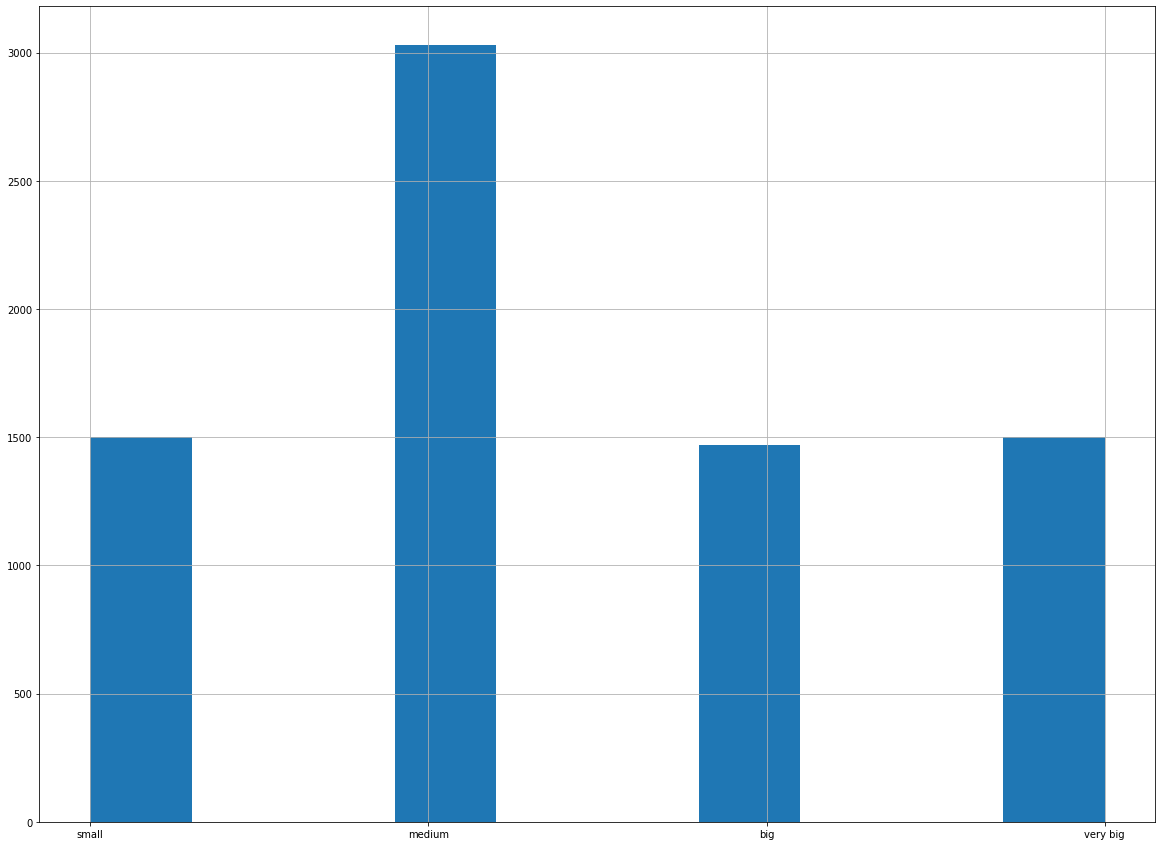

In [26]:
train_df['Annual_cut'].hist( figsize=(20,15))
plt.show

### Home Ownership

Кажется, что Have Mortgage и Home Mortgage - это одно и то же, поэтому объединяю

In [27]:
train_df['Home Ownership'].value_counts()  

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

In [28]:
def home_own(df):
        df.loc[df['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'

In [29]:
train_df.loc[train_df['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'

In [30]:
# # creating instance of labelencoder
# labelencoder = LabelEncoder()
# # Assigning numerical values and storing in another column
# train_df['Ownership_encode'] = labelencoder.fit_transform(train_df['Home Ownership'])
# df_with_dummies = pd.get_dummies(df, prefix='Category_', columns=['Category'])


### Years in current job 

Cделаем разбивку на категории:<=3, 4-6, 7-9, 10+ лет

In [31]:
train_df['Years range'] = train_df['Years in current job'].map({'< 1 year':0, 
                                                                       '1 year':0, 
                                                                       '2 years':0, 
                                                                       '3 years':0, 
                                                                       '4 years':1, 
                                                                       '5 years':1, 
                                                                       '6 years':1, 
                                                                       '7 years':2,
                                                                       '8 years':2,
                                                                       '9 years':2,
                                                                       '10+ years':3})

train_df.loc[train_df['Years range'] == 0, 'Years range'] = '0-3'
train_df.loc[train_df['Years range'] == 1, 'Years range'] = '4-6'
train_df.loc[train_df['Years range'] == 2, 'Years range'] = '7-9'
train_df.loc[train_df['Years range'] == 3, 'Years range'] = '>10'


### Credit Score

Сделаем разбивку рейтинга на категории:
    
* Excellent: 800 to 850
* Very Good: 740 to 799
* Good: 670 to 739
* Fair: 580 to 669
* Poor: 300 to 579

In [32]:
def credit_score_to_cat(X):
    bins = [300, 579, 669, 739, 799, 850]
    X['Credit Score Cat'] = pd.cut(X['Credit Score'], bins=bins, 
                                   labels=['poor','fair', 'good' , 'very good','excellent'])
    
#     X['Credit Score Cat'].fillna(-1, inplace=True)
    return X



In [33]:
train_df = credit_score_to_cat(train_df)
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Annual_cut,Years range,Credit Score Cat
0,Own Home,482087.0,10+ years,0.0,11.0,26.3,685960.0,1.0,-999.0,1.0,debt consolidation,Short Term,309573.0,47386.0,7914.0,749.0,0,small,>10,very good
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,-999.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1,medium,>10,good
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,-999.0,0.0,debt consolidation,Short Term,309573.0,308389.0,13651.0,742.0,0,small,7-9,very good
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,-999.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0,small,4-6,good
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,-999.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0,small,7-9,good


## Data preprocessing classes

Missing values and outliers

In [47]:
class DataPreprocessing:
    
    def __init__(self):
        self.medians=None
        self.modes = None
        
        
    def fit(self, X):
        """Сохранение статистик""" 
        X = X.copy()
        # Расчет медиан и мод
        self.medians = X.median()
        self.modes = X.mode().loc[0]
                
    def transform(self, X):
        
        #Outliers
        
        #credit score
        
        X.loc[train_df['Credit Score'] > 1000, 'Credit Score'] = X.loc[X['Credit Score'] > 1000, 
                                                                                     'Credit Score'] / 10
        
        X['Credit Score'].fillna(self.medians['Credit Score'], inplace = True)
        
        
        
        #Current Loan Amount
        
        X.loc[X['Current Loan Amount'] == 99999999.0, 'Current Loan Amount'] = self.medians['Current Loan Amount']
        
        
        
        #Maximum Open Credit
        
        condition = X['Current Loan Amount'] > X['Maximum Open Credit']
        X.loc[condition, 'Maximum Open Credit'] = X['Current Loan Amount']
        condition2 = X['Maximum Open Credit'] > 99999999.0
        X.loc[condition2, 'Maximum Open Credit'] = self.medians['Maximum Open Credit']
        
        
        
        
        #Missing Values
        
        #Annual Income
    
        X.loc[X['Annual Income'].isnull(), 'Annual Income'] = self.medians['Annual Income']
        
        
        
        
        #Years in current job
        
        
        X['Years in current job'].fillna(self.modes['Years in current job'], inplace = True)
        
        
        
        #Months since last delinquent
        X['Months since last delinquent'].fillna(-999, inplace=True)
        
        
        
        #Bankruptcies
        X['Bankruptcies'].fillna(self.medians['Bankruptcies'], inplace = True)
        
        
        
        #Credit Score
        
        X['Credit Score'].fillna(self.medians['Credit Score'], inplace = True)
        
        X.fillna(self.medians, inplace=True)
        
        return X
        
        
        

## New feature genereation



In [48]:
class FeatureGenetator():
    """Генерация новых фич"""
    def __init__(self):
        self.bins = None
        self.credit_bins = None
        self.medians=None
        self.modes = None 
        self.labels = None
        
    
    
    def fit(self, X, y=None):
        X = X.copy()
        self.labels = ['small', 'medium', 'big','very big']
        X['Annual_cut'] = pd.qcut(X['Annual Income'], 
                                 q = [0, .2, .4, .6, .8, 1.], labels=self.labels, duplicates='drop')
        self.bins = [X.loc[X['Annual_cut'] == 'small', 'Annual Income'].min(),
                X.loc[X['Annual_cut'] == 'small', 'Annual Income'].max(),
                X.loc[X['Annual_cut'] == 'medium', 'Annual Income'].max(),
                X.loc[X['Annual_cut'] == 'big', 'Annual Income'].max(),
                X.loc[X['Annual_cut'] == 'very big', 'Annual Income'].max()
               ]
        
        self.credit_bins = [300, 579, 669, 739, 799, 850]  
        self.modes = X.mode().loc[0]
        self.labels = ['small', 'medium', 'big','very big']
                
    def transform(self, X):
        
        
        #Annual_cut
        
 
        X['Annual_cut'] = pd.cut(X['Annual Income'], bins = self.bins, labels=self.labels, duplicates='drop')
        
        X['Annual_cut'].fillna(self.modes['Annual_cut'], inplace = True)
        
          
        #Home Ownership
        
        X.loc[X['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'
        
        X['Years range'] = X['Years in current job'].map({'< 1 year':0, 
                                                                       '1 year':0, 
                                                                       '2 years':0, 
                                                                       '3 years':0, 
                                                                       '4 years':1, 
                                                                       '5 years':1, 
                                                                       '6 years':1, 
                                                                       '7 years':2,
                                                                       '8 years':2,
                                                                       '9 years':2,
                                                                       '10+ years':3})
        
        
#         X['Credit Score Cat'] = pd.cut(X['Credit Score'], bins=self.credit_bins, 
#                                    labels=['poor','fair', 'good' , 'very good','excellent'])
        
        
        
        return X

#         train_df.loc[train_df['Years range'] == 0, 'Years range'] = '0-3'
#         train_df.loc[train_df['Years range'] == 1, 'Years range'] = '4-6'
#         train_df.loc[train_df['Years range'] == 2, 'Years range'] = '7-9'
#         train_df.loc[train_df['Years range'] == 3, 'Years range'] = '>10'

### Загрузка данных

In [161]:
train_dataset_path = '/Users/sergeismolnikov/Desktop/ML/GeekBrains/gb_ml_lib2/course_project_train.csv'
test_dataset_path = '/Users/sergeismolnikov/Desktop/ML/GeekBrains/gb_ml_lib2/course_project_test.csv'



### Отбор признаков

In [162]:
feature_names_new = [
                     'Annual_cut',
#                      'Credit Score Cat',
                     'Years range']

In [163]:
feature_names= ['Home Ownership',
                     'Annual Income',
                     'Years in current job',
                     'Tax Liens',
                     'Number of Open Accounts',
                     'Years of Credit History',
                     'Maximum Open Credit',
                     'Number of Credit Problems',
                     'Months since last delinquent',
                     'Bankruptcies',
                     'Purpose',
                     'Term',
                     'Current Loan Amount',
                     'Current Credit Balance',
                     'Monthly Debt',
                     'Credit Score',
                     ]

In [164]:
target = 'Credit Default'

len(feature_names)+len(feature_names_new)

18

### Разбиение на train и test

In [165]:
train_df = pd.read_csv(train_dataset_path)
test_df = pd.read_csv(test_dataset_path)

In [166]:
X = train_df.drop(columns=target)
y = train_df[target]

In [167]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [168]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)  #  fit применяем только к X_train

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

In [169]:
X_train.shape, X_valid.shape, test_df.shape

((6000, 16), (1500, 16), (2500, 16))

In [170]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)  #  fit применяем только к X_train, y_train

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

In [171]:
X_train.shape, X_valid.shape, test_df.shape

((6000, 19), (1500, 19), (2500, 19))

In [172]:
X_train = X_train[feature_names + feature_names_new]
X_valid = X_valid[feature_names + feature_names_new]
test_df = test_df[feature_names + feature_names_new]

In [173]:
X_train.shape, X_valid.shape, test_df.shape

((6000, 18), (1500, 18), (2500, 18))

In [174]:
test_df.isna().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Annual_cut                      0
Years range                     0
dtype: int64

In [175]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

In [176]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

2.588516746411483

In [177]:
from sklearn.metrics import make_scorer, accuracy_score

In [133]:
# clf = CatBoostClassifier()
# params = {'iterations': [500],
#           'depth': [4, 5, 6],
#           'loss_function': ['Logloss', 'CrossEntropy'],
#           'l2_leaf_reg': np.logspace(-20, -19, 3),
#           'leaf_estimation_iterations': [10],
# #           'eval_metric': ['Accuracy'],
# #           'use_best_model': ['True'],
#           'logging_level':['Silent'],
#           'random_seed': [42]
#          }
# scorer = make_scorer(accuracy_score)
# clf_grid = GridSearchCV(estimator=clf, param_grid=params, scoring=scorer, cv=5)

In [179]:
X_train_enc = X_train.apply(LabelEncoder().fit_transform)
X_train_enc.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Annual_cut,Years range
4664,2,4234,10,0,8,158,2429,0,78,0,3,1,3219,2100,4430,155,3,0
4411,2,105,10,0,3,81,1152,0,15,0,3,1,2476,20,1228,139,2,0
7448,2,1905,8,0,10,199,2929,1,0,1,3,1,1765,2410,2358,144,1,2
1919,0,2951,7,0,14,115,1827,0,16,0,3,1,2476,2325,3638,126,0,2
1298,0,4029,1,0,17,274,4290,0,42,0,3,1,2559,4933,5401,121,3,3


In [180]:
# clf_grid.fit(X_train, y_train)
# best_param = clf_grid.best_params_
# best_param

In [181]:
model = CatBoostClassifier(iterations=1000,
                           loss_function=best_param['loss_function'],
                           depth=best_param['depth'],
                           l2_leaf_reg=best_param['l2_leaf_reg'],
                           eval_metric='Accuracy',
                           class_weights=[1, disbalance],
                           leaf_estimation_iterations=10,
                           use_best_model=True,
                           logging_level='Silent',
                           random_seed=42
                          )

In [182]:
cate_features_index = np.where(X_train.dtypes != float)[0]
cate_features_index
# create a training pool for the model to fit
train_pool = Pool(X_train, y_train, cat_features=cate_features_index)

In [183]:
model.fit(train_pool, eval_set=(X_valid,y_valid))

In [184]:
def evaluate_preds(model, X_train, X_valid, y_train, y_valid):
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    print("TRAIN\n", round(f1_score(y_train, y_train_pred), 3))
    print("TEST\n", round(f1_score(y_valid, y_valid_pred), 3))
    get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

In [185]:
def get_classification_report(y_train_true, y_train_pred, y_valid_true, y_valid_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('VALID\n\n' + classification_report(y_valid_true, y_valid_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_valid_true, y_valid_pred))

In [186]:
evaluate_preds(model, X_train, X_valid, y_train, y_valid)

TRAIN
 0.531
TEST
 0.533
TRAIN

              precision    recall  f1-score   support

           0       0.85      0.61      0.71      4328
           1       0.42      0.72      0.53      1672

    accuracy                           0.64      6000
   macro avg       0.64      0.67      0.62      6000
weighted avg       0.73      0.64      0.66      6000

VALID

              precision    recall  f1-score   support

           0       0.83      0.60      0.70      1059
           1       0.42      0.72      0.53       441

    accuracy                           0.63      1500
   macro avg       0.63      0.66      0.61      1500
weighted avg       0.71      0.63      0.65      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               631  428
1               125  316


In [187]:
feature_importances = pd.DataFrame(zip(X_train.columns, model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
12,Current Loan Amount,60.134409
15,Credit Score,5.293981
1,Annual Income,5.154597
11,Term,3.195528
16,Annual_cut,3.028149
6,Maximum Open Credit,2.674274
17,Years range,2.607118
2,Years in current job,2.564916
0,Home Ownership,2.527539
14,Monthly Debt,2.220496


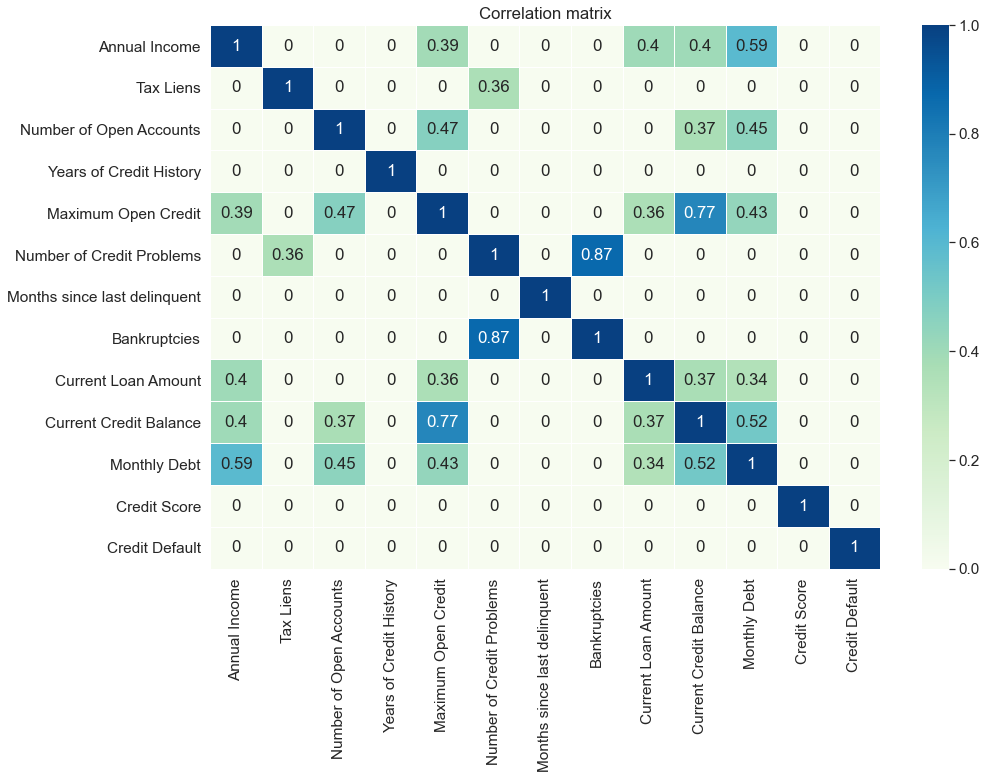

In [141]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

a = ['pearson','spearman']
corr_matrix = train_df.corr(method=a[1])
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

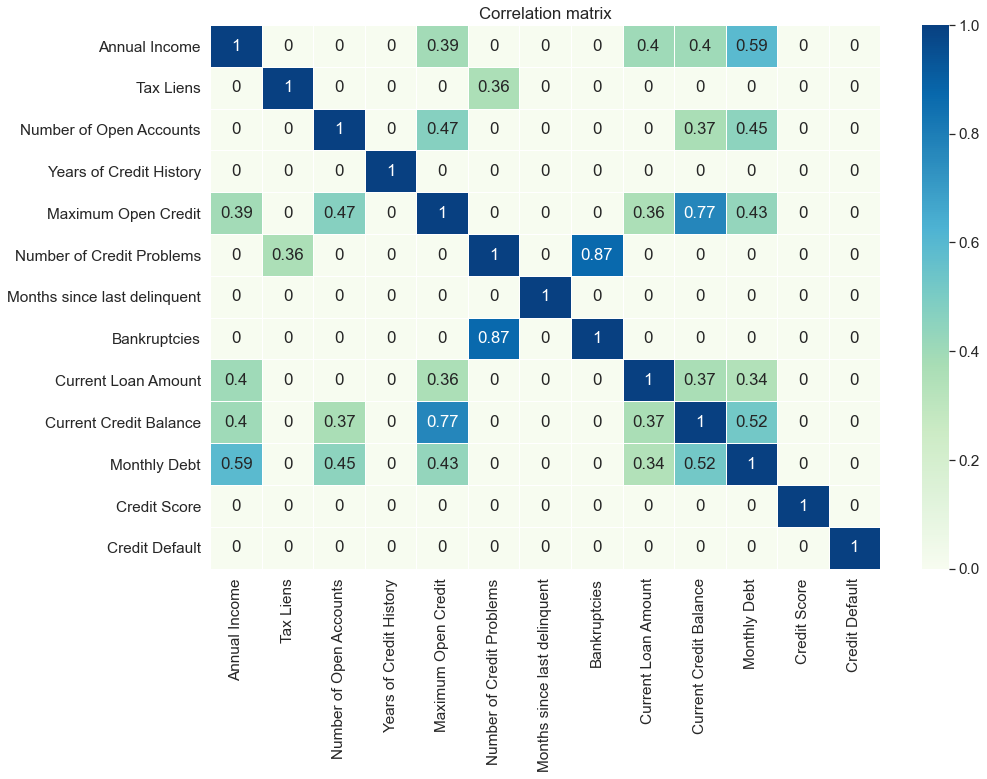

In [142]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

a = ['pearson','spearman']
corr_matrix = train_df.corr(method=a[1])
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

In [237]:
submission = pd.read_csv('/Users/sergeismolnikov/Desktop/ML/GeekBrains/gb_ml_lib2/sample_submission.csv')

In [238]:
predictions = model.predict(test_df)
predictions

array([1, 1, 0, ..., 0, 0, 0])

In [239]:
submission['Credit Default'] = pd.DataFrame(predictions, columns=['Credit Default'])

In [244]:
submission = submission.set_index('Id', drop = True)

,Id,Credit Default


In [245]:
submission.to_csv('submit.csv', index=True)